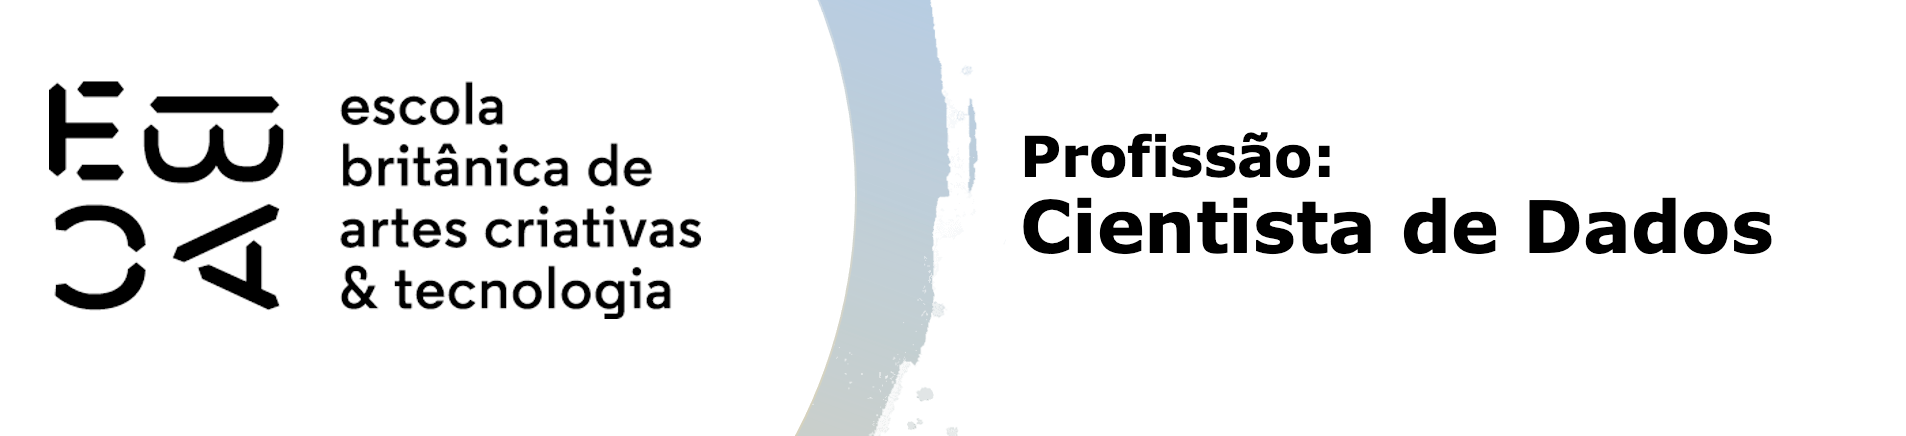

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t


In [3]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
df['safra'] = (df['data_ref'].dt.year - min(df['data_ref'].dt.year))*12 + df['data_ref'].dt.month
df.drop(inplace=True, columns=['index', 'data_ref'], errors='ignore')
df['renda'] = np.log(df.renda)

In [5]:
df.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,safra
0,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,7.830183,False,1
1,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,8.064696,False,1
2,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,7.366628,False,1
3,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,9.526695,False,1
4,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,7.969385,False,1


In [6]:
#separando os dados em treino e teste 
df_test = df[df.safra > 12].copy()
df = df[df.safra <= 12].copy()

In [7]:
# criando o dataframe de metadados das variáveis 
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
#Número de registros nulos
metadados['n_missing'] = df.isna().sum()
#Número de valores únicos
metadados['n_unique'] = df.nunique()
#Indicador se a variável é numérica 
metadados['numeric'] = (metadados.dtype == 'int64') | (metadados.dtype == 'float64')
#Tipo da variável (covarável, temporal ou resposta)
metadados['role'] = 'covariavel'
metadados.loc['mau', 'role'] = 'resposta'
metadados.loc['safra', 'role'] = 'temporal'
metadados

,dtype,n_missing,n_unique,numeric,role
sexo,object,0,2,False,covariavel
posse_de_veiculo,object,0,2,False,covariavel
posse_de_imovel,object,0,2,False,covariavel
qtd_filhos,int64,0,8,True,covariavel
tipo_renda,object,0,5,False,covariavel
educacao,object,0,5,False,covariavel
estado_civil,object,0,5,False,covariavel
tipo_residencia,object,0,6,False,covariavel
idade,int64,0,47,True,covariavel
tempo_emprego,float64,100875,3004,True,covariavel


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

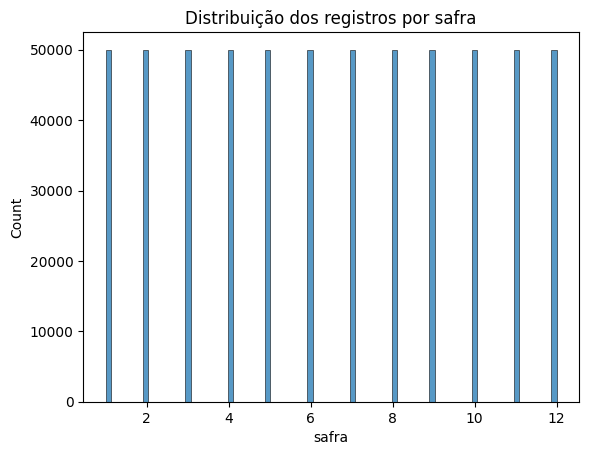

In [8]:
fig, ax = plt.subplots()
sns.histplot(df, x='safra', ax=ax)
ax.set_title('Distribuição dos registros por safra');

Observamos que os clientes estão bem distribuidos entre as safras, agora vamos verificar como está a distribuição das variáveis.

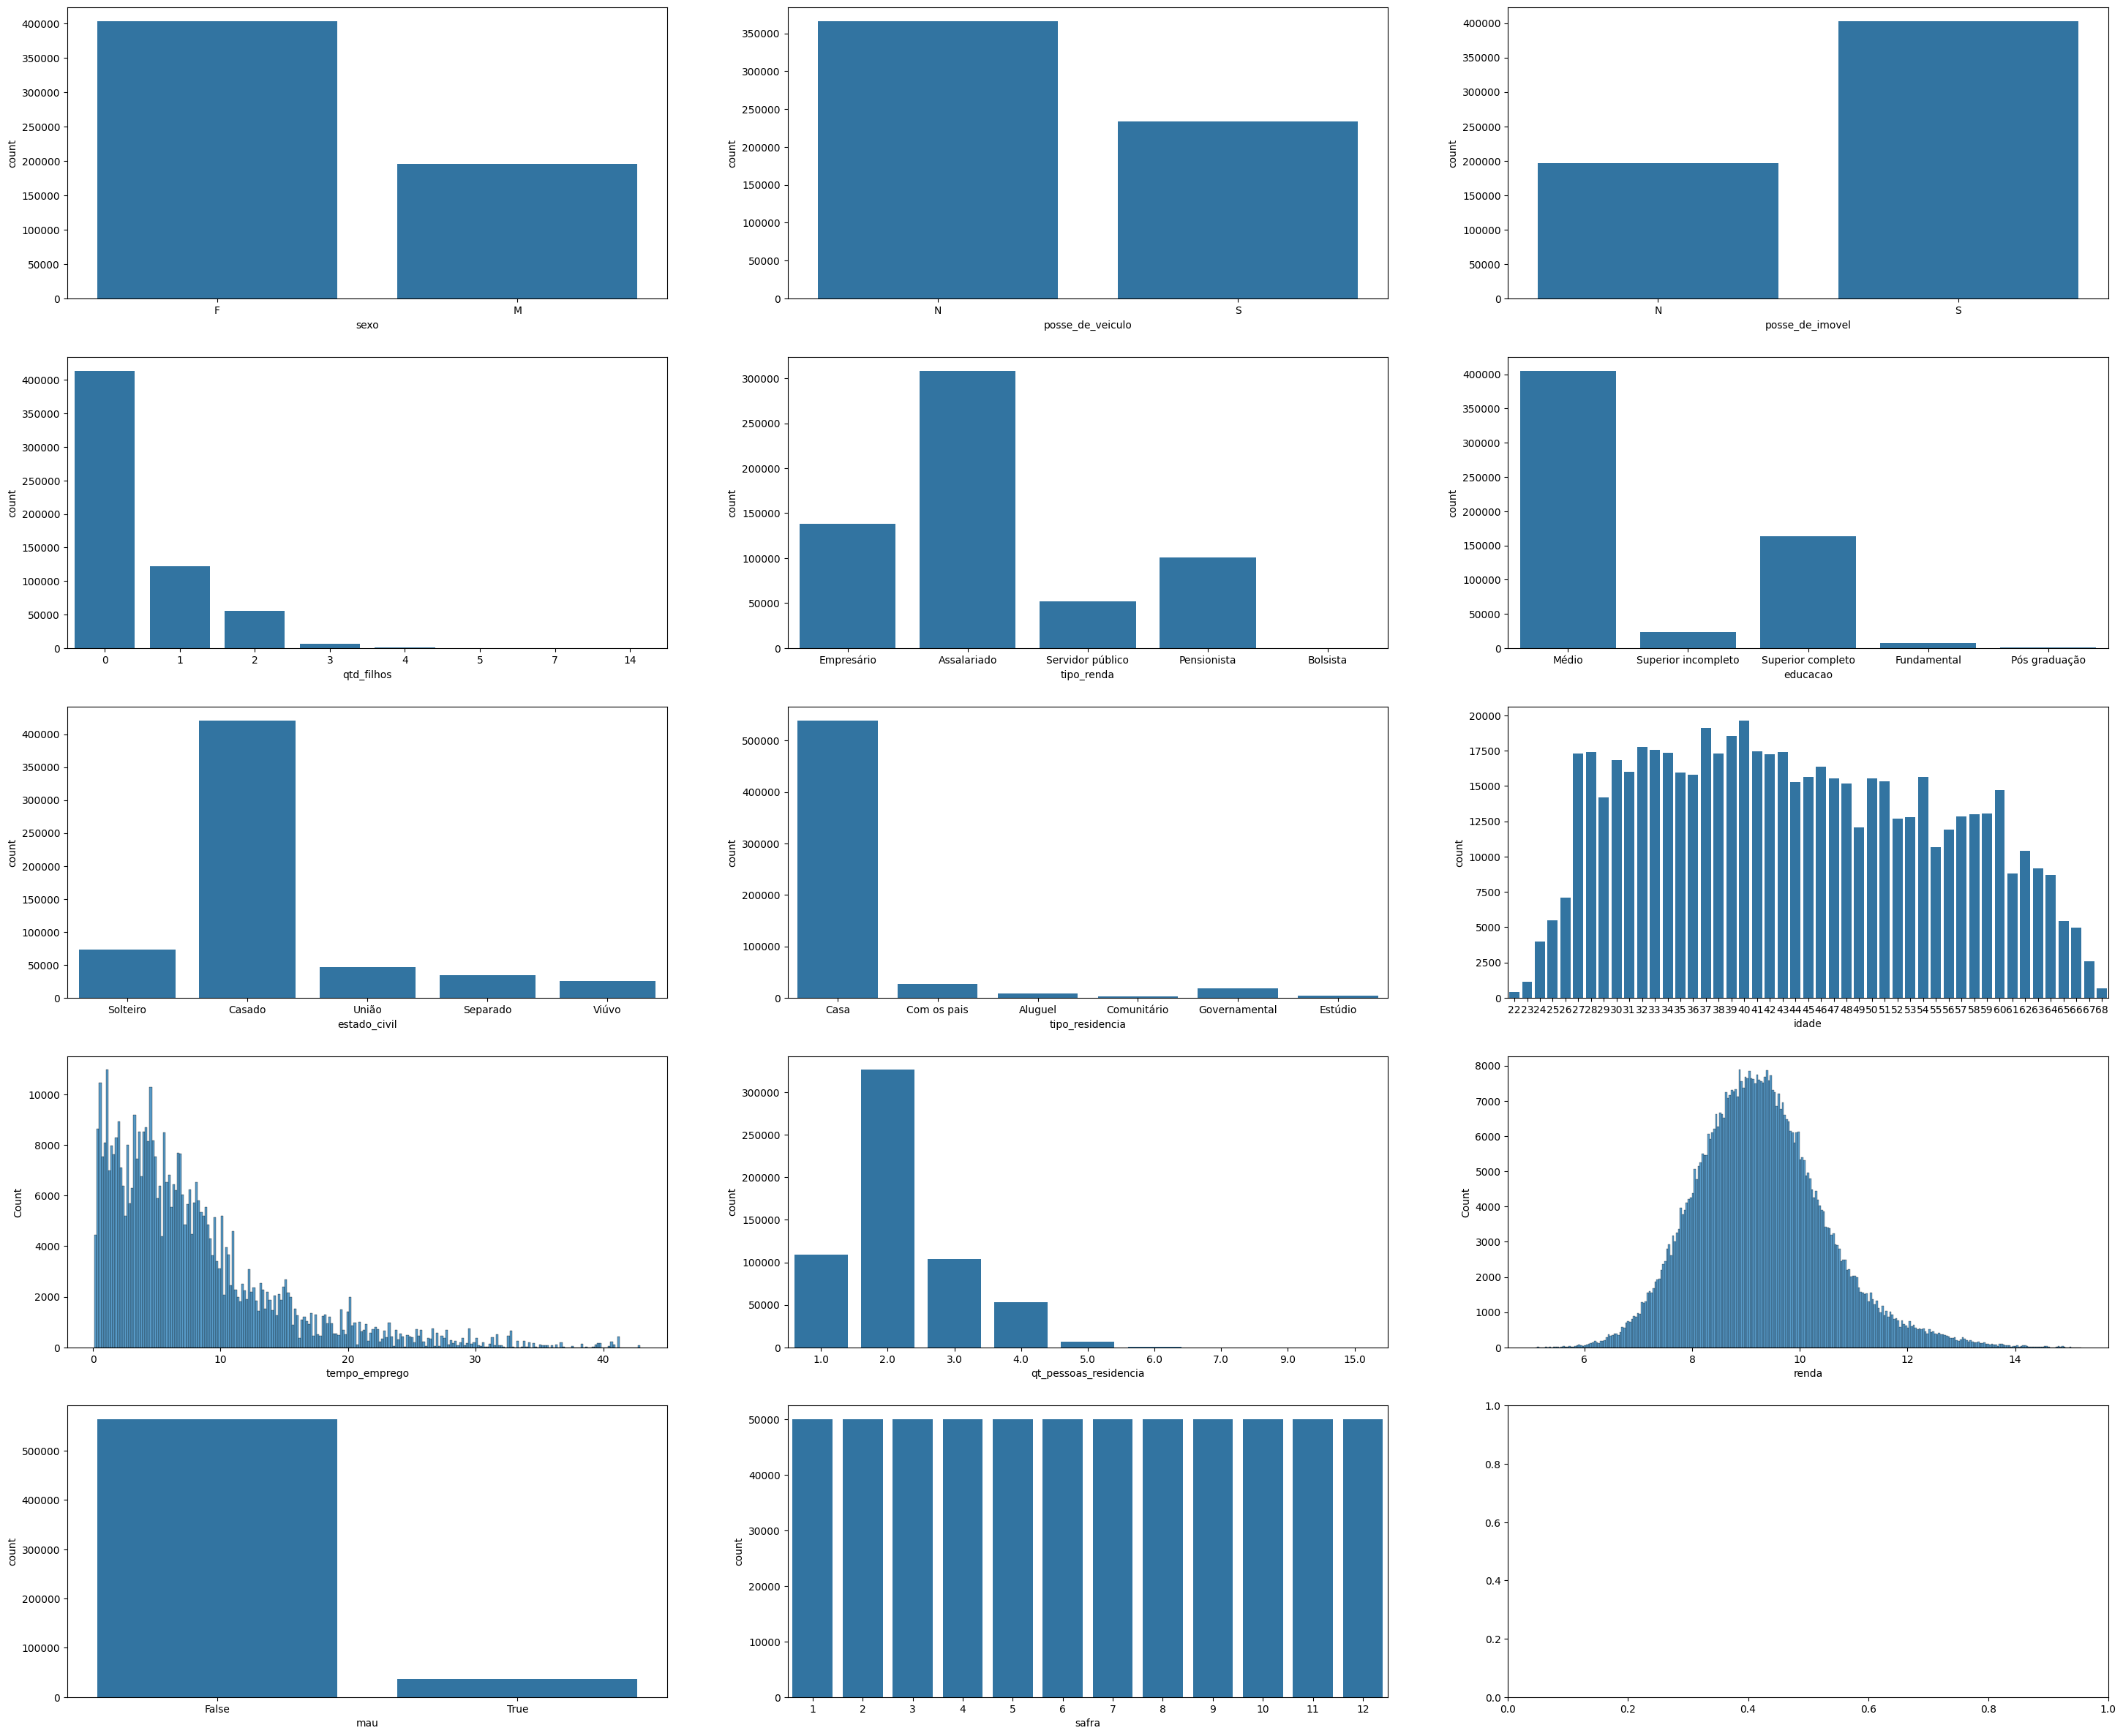

In [9]:
vars = metadados.index
n_colunas = 3
n_linhas = ceil(len(vars) / n_colunas)
fig, axs = plt.subplots(n_linhas, n_colunas, figsize=(12*n_colunas, 6*n_linhas))
for var_i, nome_var in enumerate(vars):
    ax_i = var_i // n_colunas
    ax_j = var_i % n_colunas
    if df.iloc[:,var_i].nunique() > 50:
        sns.histplot(df, x=nome_var, ax=axs[ax_i, ax_j])
    else:
        sns.countplot(df, x=nome_var, ax=axs[ax_i, ax_j])

De modo geral, as distribuições estão razoáveis. Mas, observei que qtd_filhos e qt_pessoas_residencia possuem alguns outliers que podem causar problemas se não tratados.

Por isso, optei por limitá-las em 4 e 5, respectivamente. Sendo assim, o maior valor x representa x ou mais pessoas/filhos.

In [10]:
df['qtd_filhos'] = df.qtd_filhos.clip(upper=4)
df_test['qtd_filhos'] = df_test.qtd_filhos.clip(upper=4)
df['qt_pessoas_residencia'] = df.qt_pessoas_residencia.clip(upper=5)
df_test['qt_pessoas_residencia'] = df_test.qt_pessoas_residencia.clip(upper=5)

Analisando se a distribuição das variáveis é estável no tempo.

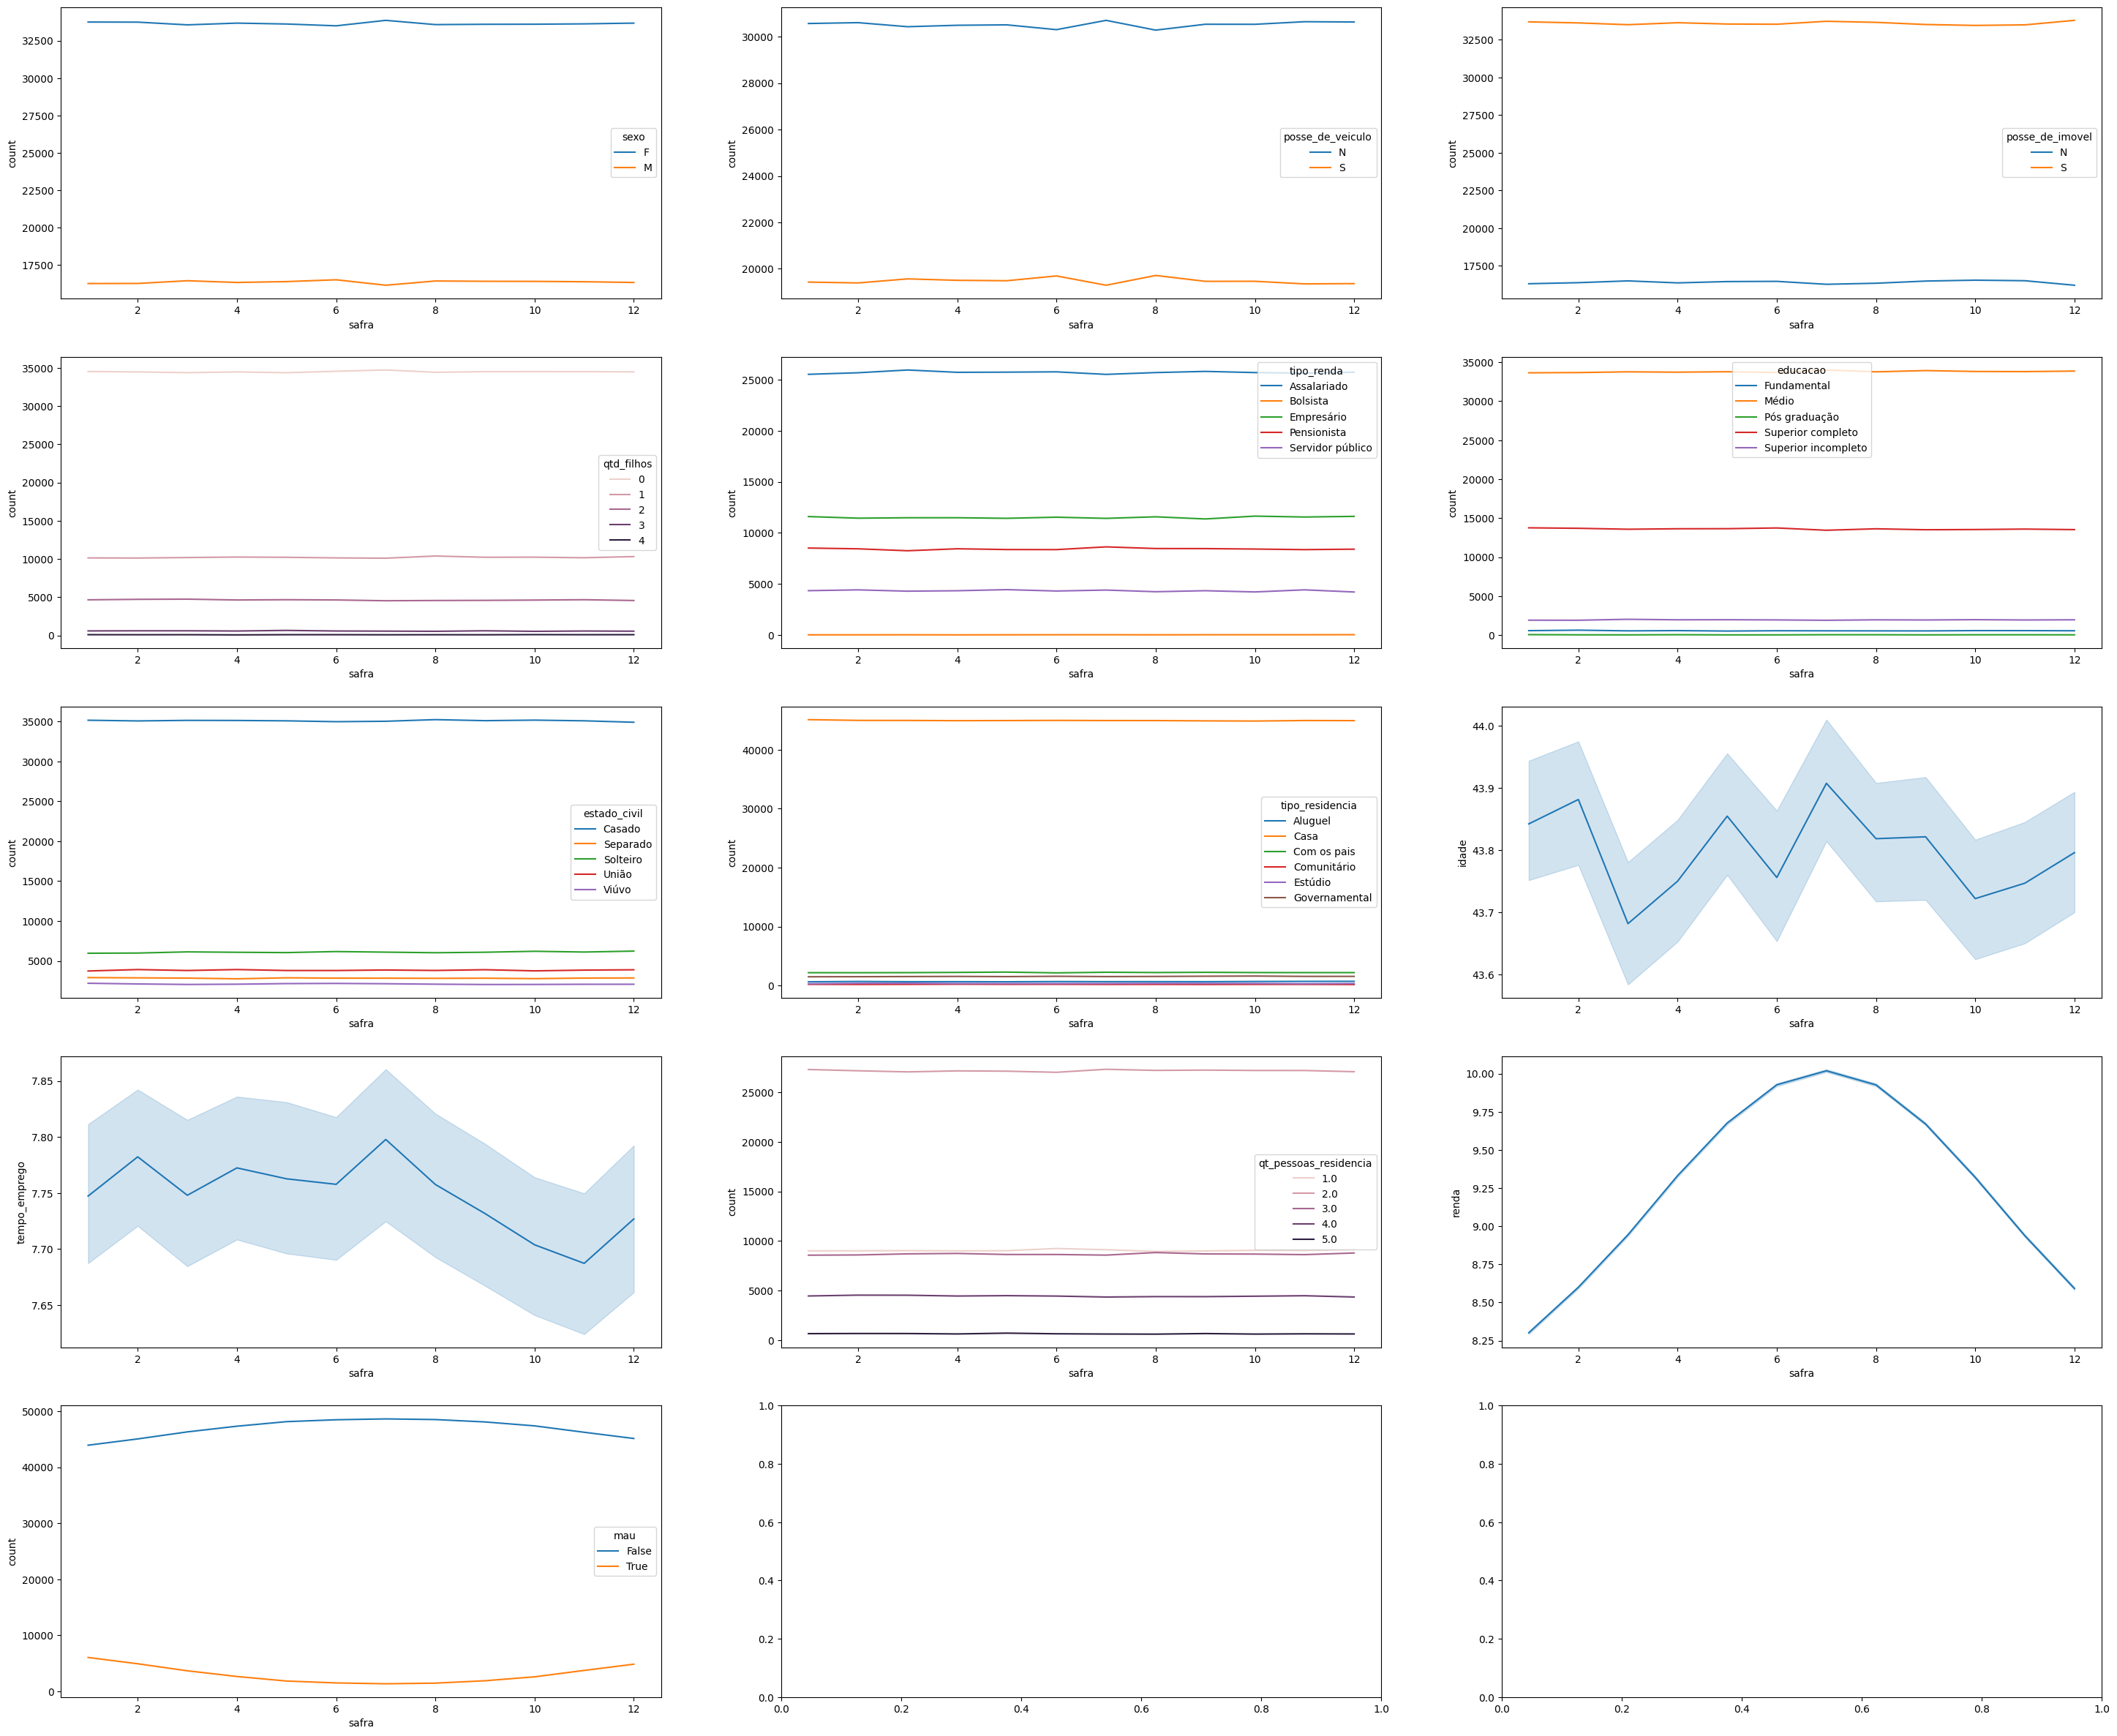

In [11]:
vars = metadados[(metadados.role != 'temporal')].index
n_colunas = 3
n_linhas = ceil(len(vars) / n_colunas)
fig, axs = plt.subplots(n_linhas, n_colunas, figsize=(12*n_colunas, 6*n_linhas))
for var_i, nome_var in enumerate(vars):
    ax_i = var_i // n_colunas
    ax_j = var_i % n_colunas
    if df.iloc[:,var_i].nunique() > 20:
        sns.lineplot(df, x='safra', y=nome_var, ax=axs[ax_i, ax_j])
    else:
        count = df.groupby([nome_var, 'safra'])['mau'].count()
        count.name = 'count'
        sns.lineplot(
            hue=count.index.get_level_values(nome_var), 
            x=count.index.get_level_values('safra'), 
            y=count, 
            ax=axs[ax_i, ax_j]
        )

Como podemos observar, duas distribuições variam no tempo:

Renda: Possui um pico próximo à safra 7, com valores mais baixos no início e fim da amostra.
Mau: A proporção de bons pagadores acompanha o aumento de renda no meio da amostra.

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [12]:
#As funções abaixo calculam o Weigth of Evidence (WOE) e Information Value (IV) de uma variável.
def iv_tab(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab

def iv(variavel, resposta):
    return iv_tab(variavel, resposta).iv_parcial.sum()

def woe(variavel, resposta):
    return iv_tab(variavel, resposta).woe.drop('total')

In [13]:
# Com isso, podemos preencher os metadados com a coluna iv.
n_quantis = 50
for nome_var in metadados[metadados.role != 'resposta'].index:
    variavel = df[nome_var]
    if (metadados.loc[nome_var, 'numeric']) and (metadados.loc[nome_var, 'n_unique'] > n_quantis):
        variavel = pd.qcut(variavel, n_quantis, duplicates='drop')
    metadados.loc[nome_var, 'iv'] = iv(variavel, df.mau)
metadados.sort_values('iv', ascending=False)

,dtype,n_missing,n_unique,numeric,role,iv
renda,float64,0,112472,True,covariavel,1.122822
tempo_emprego,float64,100875,3004,True,covariavel,0.414825
safra,int32,0,12,False,temporal,0.276492
idade,int64,0,47,True,covariavel,0.025662
tipo_renda,object,0,5,False,covariavel,0.009718
posse_de_imovel,object,0,2,False,covariavel,0.009690
educacao,object,0,5,False,covariavel,0.003690
tipo_residencia,object,0,6,False,covariavel,0.003330
sexo,object,0,2,False,covariavel,0.002665
qt_pessoas_residencia,float64,0,9,True,covariavel,0.002042


In [14]:
# criamos um novo conjunto de metatados excluindo as variáveis com iv menor que 0.02. IV's até esse valor são considerados baixos.
metadados_b = metadados.drop(metadados[(metadados.iv < 0.01)].index).sort_values('iv', ascending=False)
metadados_b

,dtype,n_missing,n_unique,numeric,role,iv
renda,float64,0,112472,True,covariavel,1.122822
tempo_emprego,float64,100875,3004,True,covariavel,0.414825
safra,int32,0,12,False,temporal,0.276492
idade,int64,0,47,True,covariavel,0.025662
mau,bool,0,2,False,resposta,NaN


Note que o Information Value da variável safra é significativo. Isso confirma o que vimos na análise univariada de que a proporção de maus pagadores varia no tempo! Vamos lembrar também, que a variável idade tem correlação com tempo_emprego, que é a principal preditora de renda no modelo de previsão desta. Tais caracteristicas indicam que essas variáveis não são úteis para o modelo de classificação de crédito.

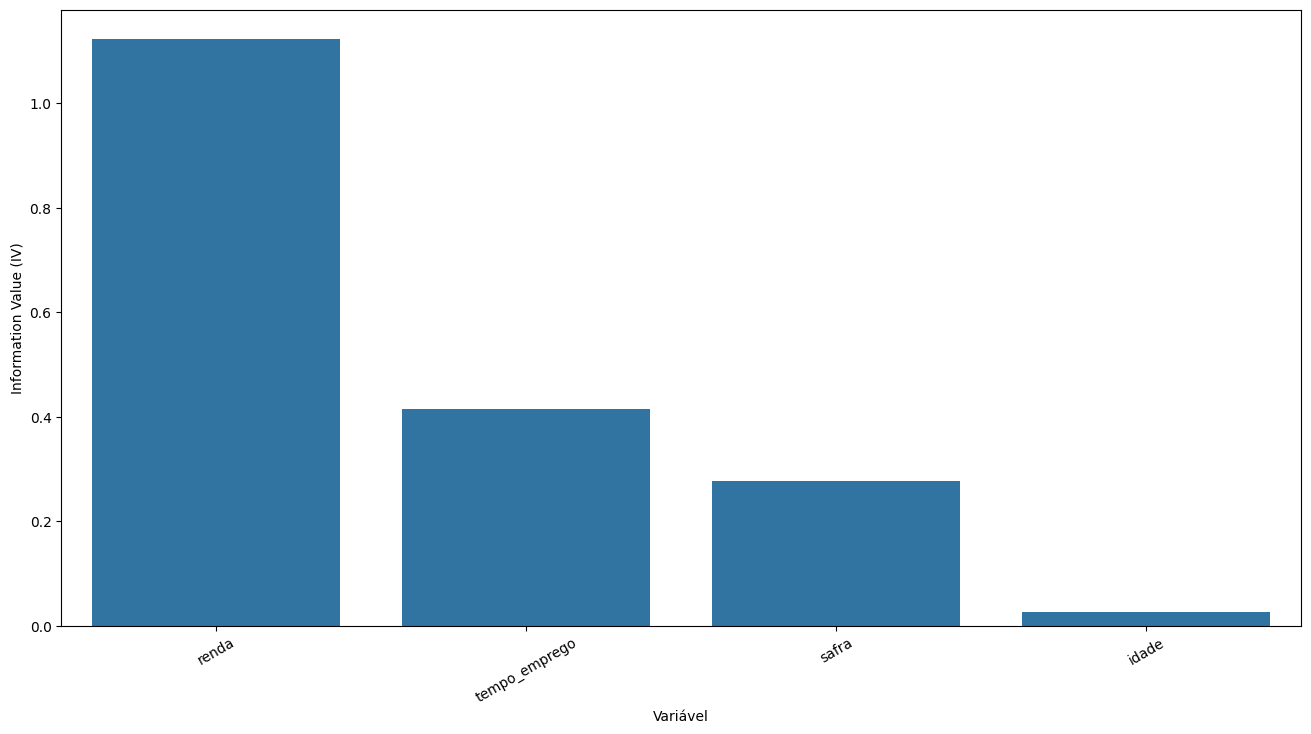

In [15]:
fig, ax = plt.subplots(figsize=(16,8))
ax.tick_params(axis='x', labelrotation = 30)
sns.barplot(metadados_b.dropna(), x=metadados_b.dropna().index, y='iv', ax=ax)
ax.set_ylabel('Information Value (IV)');
ax.set_xlabel('Variável');

In [16]:
# Agora, vamos analisar o IV das varáveis selecionados por safra. Será que elas são estáveis no tempo?
# Função para obter os IV de uma safra. Vamos passá-la para a função GroupBy.aggregate() mais adiante.
def get_iv_safra(safra: pd.DataFrame, metadados:pd.DataFrame, n_quantis: int) -> pd.Series:
    covars = [col for col in safra.columns if metadados.loc[col, 'role'] == 'covariavel']
    linha = pd.Series(index=covars, dtype='float64')
    for nome_var in covars:
        variavel = safra[nome_var]
        if (metadados.loc[nome_var, 'numeric']) and (metadados.loc[nome_var, 'n_unique'] > n_quantis):
            variavel = pd.qcut(variavel, n_quantis, duplicates='drop')
        linha.loc[nome_var] = iv(variavel, safra.mau)
    return linha

In [17]:
# Abaixo, criamos um DataFrame a partir da base de treino com as covariáveis categorizadas, a safra de cada registro e a variável resposta.
n_quantis = 10
df_cat = df[list(metadados_b.index)].copy()

for var in metadados_b.index:
    if not (metadados_b.loc[var, 'numeric']) or not (metadados_b.loc[var, 'role'] == 'covariavel'): continue
    bins = pd.qcut(df[var], n_quantis, retbins=True, duplicates='drop')[1]
    df_cat[var] = pd.cut(df_cat[var], bins, duplicates='drop')
    metadados_b.loc[var, 'numeric'] = False

df_cat

,renda,tempo_emprego,safra,idade,mau
0,"(7.804, 8.27]","(6.047, 7.458]",1,"(40.0, 43.0]",False
1,"(7.804, 8.27]","(3.63, 4.693]",1,"(33.0, 36.0]",False
2,"(5.087, 7.804]","(0.118, 1.195]",1,"(29.0, 33.0]",False
3,"(9.484, 9.802]","(11.726, 16.545]",1,"(51.0, 55.0]",False
4,"(7.804, 8.27]","(7.458, 9.093]",1,"(29.0, 33.0]",False
...,...,...,...,...,...
599995,"(9.199, 9.484]","(16.545, 42.907]",12,"(43.0, 47.0]",False
599996,"(8.27, 8.615]","(3.63, 4.693]",12,"(29.0, 33.0]",False
599997,"(8.27, 8.615]",NaN,12,"(60.0, 68.0]",True
599998,"(7.804, 8.27]","(11.726, 16.545]",12,"(36.0, 40.0]",True


In [18]:
# Aqui, criamos uma tabela de IV's por variável e safra. Isso servirá para o próximo gráfico.
safras = df_cat.groupby('safra')
safras_iv = safras.aggregate(get_iv_safra, metadados_b, n_quantis)
safras_iv.drop(columns='mau', inplace=True)
safras_iv = safras_iv.melt(ignore_index=False).reset_index()
safras_iv.rename(columns={'variable': 'variavel', 'value':'iv'}, inplace=True)
#safras_iv

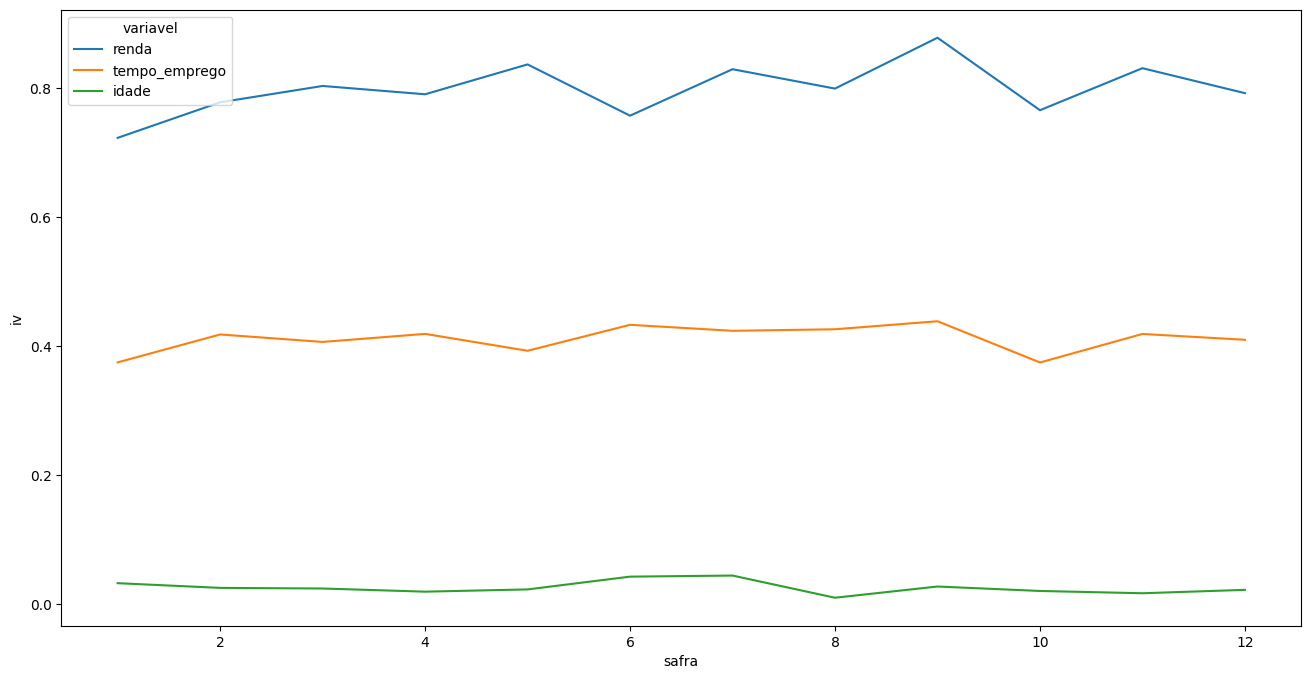

In [19]:
fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(
    data=safras_iv,
    hue='variavel', 
    x='safra', 
    y='iv', 
    ax=ax
);

Como podemos observar acima, o poder preditivo das variáveis não muda significativamente com o tempo! Porém, ainda temos algumas coisas a esclarecer:

A proporção de maus pagadores muda com o tempo.
A renda média também varia com o tempo.
Apesar disso, o poder de previsão da renda é estável.

In [20]:
woes_renda = {}
for nome, safra in safras:
    woes_renda[nome] = woe(safra.renda, safra.mau)
woes_renda = pd.DataFrame(woes_renda).melt(ignore_index=False).reset_index().rename(columns={'variable': 'safra', 'value': 'woe'})
woes_renda

,renda,safra,woe
0,"(5.087, 7.804]",1,-0.770742
1,"(7.804, 8.27]",1,0.100074
2,"(8.27, 8.615]",1,0.476161
3,"(8.615, 8.913]",1,0.850200
4,"(8.913, 9.199]",1,1.044050
...,...,...,...
115,"(9.199, 9.484]",12,1.133850
116,"(9.484, 9.802]",12,1.622782
117,"(9.802, 10.191]",12,1.605892
118,"(10.191, 10.801]",12,2.399678


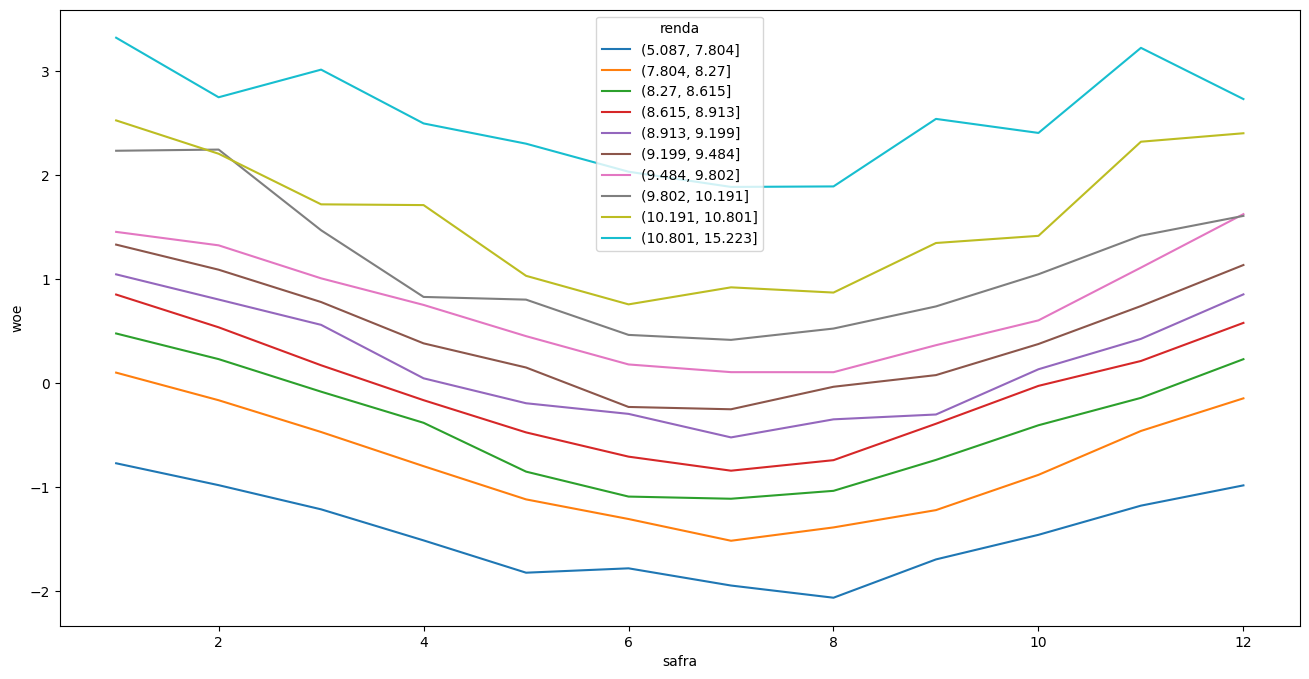

In [21]:
fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(
    data=woes_renda,
    hue='renda', 
    x='safra', 
    y='woe', 
    ax=ax
);

Analisando o gráfico acima, podemos concluir que, para cada safra, as faixas mantém um mesmo desempenho relativo. Porém, justamente onde a renda média é mais alta, o Weight of Evidence de todas as faixas de renda diminui.
Minha hipótese é que o que ajuda a prever bons e maus pagadores é renda relativa e não a renda absoluta. Vamos testar essa hipótese em seguida.

In [22]:
renda_safra = df.groupby('safra')['renda'].mean()
df['renda_safra'] = df.safra.map(renda_safra)
df['delta_renda'] = df.renda - df.renda_safra
#df

In [23]:
renda_safra = df_test.groupby('safra')['renda'].mean()
df_test['renda_safra'] = df_test.safra.map(renda_safra)
df_test['delta_renda'] = df_test.renda - df_test.renda_safra
#df_test

In [24]:
n_quantis = 20
delta_renda_cat = pd.qcut(df.delta_renda, n_quantis, duplicates='drop')
iv = {
    'renda_safra': iv(df.renda_safra, df.mau),
    'delta_renda': iv(delta_renda_cat, df.mau)
}
iv = pd.Series(iv)

In [25]:
iv

renda_safra    0.276492
delta_renda    0.800145
dtype: float64

Na verdade, as duas componentes da variável renda são importantes.

Porém, separá-las permite ao nosso modelo distinguir caso haja uma diferença de peso entre clientes ricos e pobres versus períodos de maior ou menor renda.

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

**Preparação do Modelo**

Outliers e zeros estruturais estavam causando problemas na análise descritiva e já foram tratados.

Além disso, todas as variáveis categóricas acabaram por serem descartadas por terem IV muito baixo. Por isso não faz sentido unir categorias.

Apenas a variável tempo_emprego possui valores missing.

In [26]:
df.dropna(inplace=True)
df_test.dropna(inplace=True)

In [27]:
#O StatsModels não aceita trabalhar com variável resposta tipo bool
df['mau'] = df.mau.astype('int8')
df_test['mau'] = df_test.mau.astype('int8')

Abaixo, treinamos o modelo. Das variáveis avaliadas, a única que é significativa é a renda. Além disso, separá-la em renda_safra e delta_renda parece não melhorar significativamente o modelo. 

In [28]:
vars = ['renda']
formula = f'mau ~ {"+".join(vars)}'
reg = smf.glm(formula, df, family=sm.families.Binomial()).fit()

In [29]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               499125
Model:                            GLM   Df Residuals:                   499123
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -98410.
Date:                Fri, 27 Jun 2025   Deviance:                   1.9682e+05
Time:                        20:15:39   Pearson chi2:                 4.96e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.06012
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9441      0.053    112.883      0.000       5.841       6.047
renda         -0.9935      0.006   -157.559      0.000      -1.006      -0.981
==============================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [30]:
def model_stats(df, reg):
    df['pred'] = reg.predict(df)

    acc = metrics.accuracy_score(df.mau == 1, df.pred >= .5)

    fpr, tpr, thresholds = metrics.roc_curve(df.mau, df.pred)
    auc = metrics.auc(fpr, tpr)

    gini = 2*auc - 1

    true_pred_test = df.loc[df.mau == 1, 'pred'] 
    false_pred_test = df.loc[df.mau == 0, 'pred']
    ks = ks_2samp(true_pred_test, false_pred_test).statistic

    return acc, auc, gini, ks


In [31]:

#Base de treino
acc, auc, gini, ks = model_stats(df, reg)

print(f'Treino:\nPct. Bom:{1 - df.mau.mean(): .2%}\nAcurácia: {acc:.2%} \nAUC: {auc:.2%} \nGINI: {gini:.2%}\nKS: {ks:.2%}')



Treino:
Pct. Bom: 93.96%
Acurácia: 93.97% 
AUC: 77.80% 
GINI: 55.61%
KS: 41.16%


In [32]:
#Base de teste
acc, auc, gini, ks = model_stats(df_test, reg)

print(f'Teste:\nPct. Bom:{1 - df_test.mau.mean(): .2%}\nAcurácia: {acc:.2%} \nAUC: {auc:.2%} \nGINI: {gini:.2%}\nKS: {ks:.2%}')

Teste:
Pct. Bom: 85.53%
Acurácia: 85.69% 
AUC: 74.90% 
GINI: 49.80%
KS: 36.38%


**Conclusão**


Considerando que o modelo possui apenas uma variável,  entendo que a classificação de clientes é razoável. 
Entendo que podemos melhorar bastante, sendo que aproveitamos apenas uma variável do dataset fornecido, que não contém dados com relação à pontuação nos birôs de crédito e hábitos de consumo.

**Módulo 38**

# A) Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

In [34]:
log_renda = ColumnTransformer([('log_renda', FunctionTransformer(np.log), ['renda'])], remainder='passthrough')

In [35]:
fillna = SimpleImputer(strategy='mean')

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [36]:
limita_outliers = ColumnTransformer(
    [
        ('qtd_filhos', FunctionTransformer(np.clip, kw_args={'a_max': 3}), ['qtd_filhos']),
        ('qtd_pessoas', FunctionTransformer(np.clip, kw_args={'a_max': 5}), ['qt_pessoas_residencia'])
    ], 
    remainder='passthrough')

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [37]:
seletor = SelectFromModel(LogisticRegression())

In [38]:
vars_num = metadados[metadados.numeric].index
vars_cat = metadados[~metadados.numeric].index

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [39]:
pca = PCA(n_components=5)

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [40]:
dummies_scaling = ColumnTransformer([
    ('one_hot', OneHotEncoder(), vars_cat),
    ('std_scaler', StandardScaler(), vars_num)
])

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [41]:
pipeline = Pipeline([
    ('log_renda', log_renda),
    ('limita_outliers', limita_outliers),
    ('fillna', fillna),
    ('dummies_scaling', dummies_scaling),
    ('seletor', seletor),
    ('pca', pca)
])

# B) Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.


In [42]:
df = pd.read_feather('credit_scoring.ftr').dropna()
df['safra'] = (df['data_ref'].dt.year - min(df['data_ref'].dt.year))*12 + df['data_ref'].dt.month
df = df.reindex(columns=['renda'] + [col for col in df.columns if col != 'renda'])

Resolvi remover os valores nulos fora do Pycaret porque a opção numeric_imputation='drop' estava dando problema na hora de gerar previsões.

In [43]:
df_test = df[df.safra > 12]
df_train = df[df.safra <= 12]

In [1]:
pip install pycaret

  Using cached pycaret-3.3.2-py3-none-any.whl.metadata (17 kB)
  Using cached ipywidgets-8.1.7-py3-none-any.whl.metadata (2.4 kB)
  Using cached pandas-2.1.4-cp312-cp312-win_amd64.whl.metadata (18 kB)
  Using cached pyod-2.0.5-py3-none-any.whl.metadata (46 kB)
  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached category_encoders-2.8.1-py3-none-any.whl.metadata (7.9 kB)
  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
  Using cached matplotlib-3.7.5-cp312-cp312-win_amd64.whl.metadata (5.8 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl.metadata (7.1 kB)
  Using cached yellowbrick-1.5-py3-none-any.whl.metadata (7.7 kB)
  Using cached kaleido-1.0.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached plotly_resampler-0.10.0-py3-none-any.whl.metadata (13 kB)
  Using cached sktime-0.26.0-py3-none-any.whl.metadata (29 kB)
  Using cached tbats-1.1.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached pmdarima-2.0.4-cp312-cp312-win_amd

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 5] Acesso negado: 'c:\\users\\cristiane.santos6\\appdata\\local\\programs\\python\\python312\\lib\\site-packages\\matplotlib\\backends\\_backend_agg.cp312-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [1]:
from pycaret.classification import *

ModuleNotFoundError: No module named 'pycaret'

In [2]:
from pycaret.classification import models

ModuleNotFoundError: No module named 'pycaret'

In [3]:
import pycaret as pyt

ModuleNotFoundError: No module named 'pycaret'

In [ ]:


exp = setup(
    data=df_train.sample(frac=0.1), 
    target='mau',
    numeric_imputation='mean',
    ignore_features=['index', 'data_ref', 'safra'],
    max_encoding_ohe=-1,
    remove_outliers=True,
    outliers_method='lof',
    pca=True,
    pca_components=5,
    normalize=True,
    feature_selection=False,
    feature_selection_method='classic',
    custom_pipeline=Pipeline([('log_renda', log_renda)]),
    custom_pipeline_position=0,
    fold_strategy='timeseries',
    fold=5,
)

ModuleNotFoundError: No module named 'pycaret'

In [ ]:
clf = create_model('lightgbm', min_data_in_leaf=20)

Para ajustar os hiperparâmetros e melhorar o modelo, descomente a segunda linha abaixo. É uma operação demorada.

In [ ]:
tuned_clf = clf
#tuned_clf = tune_model(clf, fold=3)

In [ ]:
plot_model(tuned_clf, 'auc')

In [ ]:
plot_model(tuned_clf, 'ks')

In [ ]:
plot_model(tuned_clf, 'pr')

In [ ]:
plot_model(tuned_clf, 'feature')

In [ ]:
plot_model(tuned_clf, 'confusion_matrix')

In [ ]:
final_clf = finalize_model(tuned_clf)

In [ ]:
pred_train = predict_model(final_clf)

In [ ]:
pred_test = predict_model(final_clf, data=df_test)

In [ ]:
from datetime import date
save_model(final_clf, f'final_credit_clf_ {date.today()}')